# init

In [1]:
# math stuff
import numpy as np
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
# sliders
from ipywidgets import interactive

# to be able to use python files
import sys 
sys.path.append('pyfiles/')
import classes as cl
# This reloads external modules every time a cell is run
# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2
import csv #for loading function

# for matrix import and display
import pandas as pd
from IPython.display import display_html  # this is needed to display pretty matrices side by side

# input shape

### parametric eq for ellipse: 
$F(t) = (x(t), y(t))$, where $x(t) = a*cos(t)$ and $y(t) = b*sin(t)$

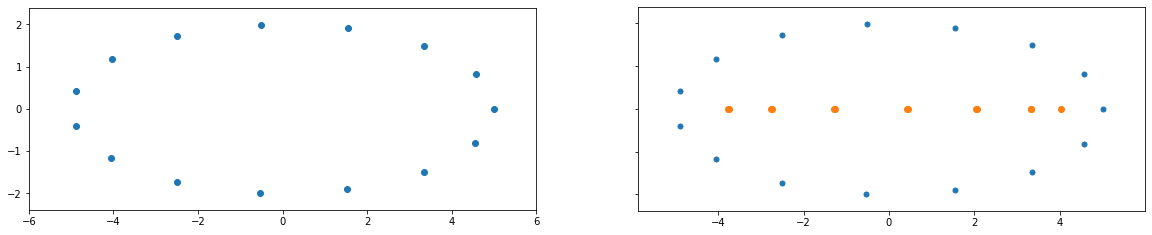

In [2]:
# parameters for ellipse shape and sampling density
a = 5
b = 2

# c is sampling density: smaller is more dense
# c = .01
# c = 9
c = 15
t = np.arange(0.0, 6.28, 6.28/c)
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True)
x = a*np.cos(t)
y = b*np.sin(t)
points = np.array(list(zip(x,y)))
vor = Voronoi(points)

# plot ellipse
ax1.set_xlim(-(max(a,b) + 1), (max(a,b) + 1))
ax1.set_ylim(-(max(a,b) + 1), (max(a,b) + 1))
ax1.set_aspect('equal')
ax1.plot(x,y,'o')

# plot voronoi stuff
ax2.set_xlim(-(max(a,b) + 1), (max(a,b) + 1))
ax2.set_ylim(-(max(a,b) + 1), (max(a,b) + 1))
ax2.set_aspect('equal')
voronoi_plot_2d(vor, ax2, show_vertices=True, line_alpha = 0, show_points = True, point_colors='orange', point_size=10)

fig.set_figwidth(20)
fig.set_figheight(20)
plt.show()

# turn points into simplices and add connecting edges 

In [3]:
init_complex = cl.complex()
i = 0
# we give the complex vertices
for point in points:
    temp_simplex = cl.simplex()
    temp_simplex.coords = [round(point[0],2), round(point[1],2)]
    temp_simplex.index = i
    temp_simplex.dim = 0
    temp_simplex.boundary = [-1]
    i += 1
    init_complex.vertlist.append(temp_simplex)
#     init_complex.nverts += 1


complexx = deepcopy(init_complex)

# add edges to complexx
for i in range(len(init_complex.vertlist)):
    temp_edge = cl.simplex()
    temp_edge.boundary = [i, (i + 1)%(len(init_complex.vertlist))]
    temp_edge.dim = 1
    temp_edge.index = i + 1 # maybe this makes no sense
    complexx.edgelist.append(temp_edge)
#     complexx.nedges += 1
    i += 1

print(complexx)
print(init_complex)

number of verts is 15, and number of edges is 15
number of verts is 15, and number of edges is 0


[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


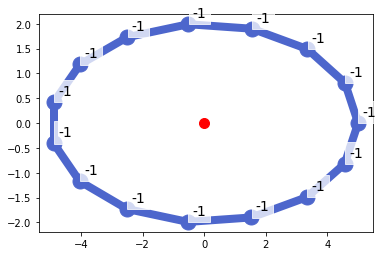

In [4]:
complexx.plot()

# use distance from special point to create ordering on all simplices 
note: maybe don't start with point on curve

In [5]:
#repeating because maybe we can just do this at the same time

orderedcplx = deepcopy(cl.complex())
# the key point is the one we will take the squared dist from
orderedcplx.key_point = init_complex.vertlist[0].coords
orderedcplx.key_point = (0,0)
distlist = []
# find distance-squareds
for i in range(len(init_complex.vertlist)):
    temp_simplex = init_complex.vertlist[i]
    dist = distance.euclidean(orderedcplx.key_point, temp_simplex.coords)
    distsq = round(dist*dist,2)
    temp_simplex.radialdist = distsq
    distlist.append(distsq)
    # reset the index
    temp_simplex.index = i
    orderedcplx.vertlist.append(temp_simplex)
    i += 1
# orderedcplx.vertlist
print(distlist)
# at this point, orderedcplx has the verts, and they each have .radialdist as their dist

[25.0, 21.54, 13.44, 6.01, 4.23, 9.24, 17.71, 24.09, 24.08, 17.77, 9.29, 4.24, 5.95, 13.38, 21.47]


## ondra's magical way to permute the indices

In [6]:
# sorts by distlist[ind] but in case of tie, ind breaks tie
# "" sorts by radius, but then uses input index to consistently break ties

# I think we have to make a new list here
old_indices = []
for i in range(len(orderedcplx.vertlist)):
    old_indices.append(orderedcplx.vertlist[i].index)
    
for new_i, i in enumerate(sorted(old_indices, key = lambda ind: (distlist[ind], ind))):
    orderedcplx.vertlist[i].orderedindex = new_i
    
orderedcplx.print_inds()
# now, orderedcplx has a correct orderedindex for every vert
# edges still need to be indexed based on this ordering

<bound method complex.nverts of number of verts is 15, and number of edges is 0>  indices
orig  0  new:  14
orig  1  new:  11
orig  2  new:  7
orig  3  new:  3
orig  4  new:  0
orig  5  new:  4
orig  6  new:  8
orig  7  new:  13
orig  8  new:  12
orig  9  new:  9
orig  10  new:  5
orig  11  new:  1
orig  12  new:  2
orig  13  new:  6
orig  14  new:  10


# sort the verts

In [7]:
# note

# if column is repr as set of indices, max yields lowest one
# max can (maybe) be re-keyed to return max wrt ie radius instead of index
# max(column, key=...), key as lambda funcion like for enumerate

# consider redoing matrices? 

[25.0, 21.54, 13.44, 6.01, 4.23, 9.24, 17.71, 24.09, 24.08, 17.77, 9.29, 4.24, 5.95, 13.38, 21.47]


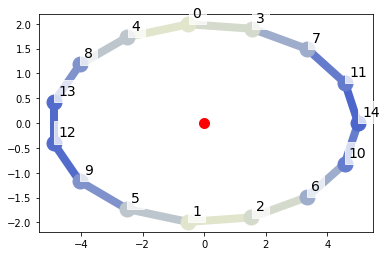

In [8]:
# TODO: DECIDE ON RULE FOR THE BOUNDARY: INITIAL INPUT OR ORDERED
# we want to put them into the matrix in order but we'll change it later


# add unordered edges
# add edges to complexx

# we initialize these empty here so we can rerun this without getting spurious values
orderedcplx.edgelist = []
for vert in orderedcplx.vertlist: 
    vert.parents = []
    
for i in range(len(orderedcplx.vertlist)):
    temp_edge = cl.simplex()
    j = (i + 1)%(len(init_complex.vertlist))
    # i is the first vert in the edge, and j is the second. 
    # this assumes we are dealing with a closed loop, in which case
    # the final vertex is the 0th vert.
    
    #NOTE: the boundary should be actual simplices, not just ints
    temp_edge.boundary = [i, j]
#     temp_edge.boundary = [orderedcplx.vertlist[i].orderedindex, orderedcplx.vertlist[j].orderedindex]
    temp_edge.dim = 1
    temp_edge.index = i # maybe this makes no sense
    temp_edge.coords = [[orderedcplx.vertlist[i].coords],[orderedcplx.vertlist[j].coords]]
    
    # here the index of the edges is NOT unique over all simplices, because it's just in the for loop, so
    # we can't tell the difference between an edge and a vertex by just the index
    orderedcplx.vertlist[i].parents.append(i)
    orderedcplx.vertlist[j].parents.append(i)
    
    # does this yield a unique ordering? 
    temp_edge.orderedindex = max(orderedcplx.vertlist[i].orderedindex, orderedcplx.vertlist[j].orderedindex )
    orderedcplx.edgelist.append(temp_edge)
    i += 1
orderedcplx.plot()
# print([v.index for v in orderedcplx.vertlist])

## Next we want to build the persistence matrix.

In [9]:
for vertex in orderedcplx.vertlist:
    print("my index is ", vertex.index, \
          " and my parents are ", vertex.parents, \
          " my function value is ", vertex.orderedindex)
print("\n")    
for edge in orderedcplx.edgelist:
    print("my index is ", edge.index, \
          " and my children are ", edge.boundary, \
          " my function value is ", edge.orderedindex)

my index is  0  and my parents are  [0, 14]  my function value is  14
my index is  1  and my parents are  [0, 1]  my function value is  11
my index is  2  and my parents are  [1, 2]  my function value is  7
my index is  3  and my parents are  [2, 3]  my function value is  3
my index is  4  and my parents are  [3, 4]  my function value is  0
my index is  5  and my parents are  [4, 5]  my function value is  4
my index is  6  and my parents are  [5, 6]  my function value is  8
my index is  7  and my parents are  [6, 7]  my function value is  13
my index is  8  and my parents are  [7, 8]  my function value is  12
my index is  9  and my parents are  [8, 9]  my function value is  9
my index is  10  and my parents are  [9, 10]  my function value is  5
my index is  11  and my parents are  [10, 11]  my function value is  1
my index is  12  and my parents are  [11, 12]  my function value is  2
my index is  13  and my parents are  [12, 13]  my function value is  6
my index is  14  and my parents 

## at the moment, ordering is not unique. procedure: 
- try to use lambda functional that runs over both verts and edges. It sorts first by simplex.orderedindex, then by dimension (verts before edges), then by initial index (in case of ties between edges)

## this gives a total order on verts and edges, first by function value, and then by dimension, and then by initial index

In [10]:
all_simplices = orderedcplx.vertlist + orderedcplx.edgelist
simplex_key = lambda simplex: (simplex.orderedindex, len(simplex.boundary), simplex.index)
all_simplices.sort(key=simplex_key)

for i in range(len(all_simplices)):
    all_simplices[i].columnvalue = i
all_simplices


# check that it also altered original simplices
# check was a success
# for i in range(len(orderedcplx.vertlist)):
#     print(orderedcplx.vertlist[i])

[simplex ind is 4, dim is 0, boundary is [-1], ord ind is 0, and column val is 0,
 simplex ind is 11, dim is 0, boundary is [-1], ord ind is 1, and column val is 1,
 simplex ind is 12, dim is 0, boundary is [-1], ord ind is 2, and column val is 2,
 simplex ind is 11, dim is 1, boundary is [11, 12], ord ind is 2, and column val is 3,
 simplex ind is 3, dim is 0, boundary is [-1], ord ind is 3, and column val is 4,
 simplex ind is 3, dim is 1, boundary is [3, 4], ord ind is 3, and column val is 5,
 simplex ind is 5, dim is 0, boundary is [-1], ord ind is 4, and column val is 6,
 simplex ind is 4, dim is 1, boundary is [4, 5], ord ind is 4, and column val is 7,
 simplex ind is 10, dim is 0, boundary is [-1], ord ind is 5, and column val is 8,
 simplex ind is 10, dim is 1, boundary is [10, 11], ord ind is 5, and column val is 9,
 simplex ind is 13, dim is 0, boundary is [-1], ord ind is 6, and column val is 10,
 simplex ind is 12, dim is 1, boundary is [12, 13], ord ind is 6, and column va

## build the boundary matrix

In [11]:
# NOTE: Matrix is for reduced homology, so it starts with the empty set in col 0.
# also to note: we use one big matrix for edges and verts, so they are intermingled.

In [12]:
mat = cl.bdmatrix()

# next we want to make a function that builds a np array from the ordered cplx. 
# it will be a square matrix, with length nedges + nverts + 1 (because of empty simplex for reduced homology)
# NOTE: WE DON'T ALLOW FOR TRIANGLES YET BUT EVENTUALLY SHOULD

# simplices in filtration order across top and same order going down
# child is going down and parent is across 
# if child i in parent j, (i,j) row,column gets a 1
# for all vert parents: they all get a 1 for empty set and 0 else

# note from Teresa: we can separate the matrices into one each for verts, edges, triangles, 
# ... not sure if this is better in practice

n = len(orderedcplx.vertlist) + len(orderedcplx.edgelist) + 1
orderedmat = np.zeros((n,n), dtype=int)

# give all verts columns a 1 at position 0 because of empty simplex
for i in range(len(orderedcplx.vertlist)):
    # column (orderedcplx.vertlist[i].columnvalue + 1), row 0, gets a 1
    orderedmat[0][orderedcplx.vertlist[i].columnvalue + 1] = 1
    
# next, go over edges
for i in range(len(orderedcplx.edgelist)):
    # column (orderedcplx.edgelist[i].columnvalue + 1), row j, gets a 1 if 
    # orderedcplx.edgelist[i].boundary contains j
    index_k = orderedcplx.edgelist[i].boundary[0]
    index_m = orderedcplx.edgelist[i].boundary[1]
    # now need to find row containing index k,m. 
    # it is of form simplx.columnvalue = k
    # need to find simplex.columnvalue s.t. simplex.index = k
    for x in orderedcplx.vertlist:
        if x.index == index_k:
            orderedmat[x.columnvalue + 1][orderedcplx.edgelist[i].columnvalue + 1] = 1
            break
    else:
        x = None
    for x in orderedcplx.vertlist:
        if x.index == index_m:
            orderedmat[x.columnvalue + 1][orderedcplx.edgelist[i].columnvalue + 1] = 1
            break
    else:
        x = None

mat.initmatrix = orderedmat
orderedmat

array([[0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [13]:
reduced = mat.reduce();

columns:  31  rows:  31


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0
1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# next: in reduced matrix, count number of 0-columns for each dim
# then count number of lowest ones for each dim
reduced
length = len(reduced[:][0])
# check that the first column is a 0 column
# (reduced homology means it should always be a 0 col)
for i in range(length):
    if reduced[length - i - 1][0] == 1:
        print("ERROR! this is supposed to be a zero column, but there is a 1 at row ", length - i -1)
        break
        
# next, for column j in the matrix, check from bottom for lowest ones. 
# if there is a lowest one, check the column (j), and find the corresponding
# simplex columnvalue. Check the dimension. Add to the count in bdmatrix.counts 
# for lowest one. 
# if no ones are found, then it is a zero column, and add that 
# to the corresponding zero column count. 

# spits out row value for lowest one in a column
zerocol = True
for j in range(length):
    # we know it's a square matrix by construction 
    for i in range(length):
        # here we go backwards up the columns to search for lowest ones.
        if reduced[length - i - 1][j] == 1:
            print("the lowest one in column ",j, "is at row ", length - i -1)
            # check what dimension it is
            # find simplex in all_simplices s.t. simplex.columnvalue = j
            for x in all_simplices:
                # j-1 because of the dummy column at the beginning. 
                # I think this is the only change we need to make.
                if x.columnvalue == j - 1:
                    print("   the simplex has index ", x.index, " and dimension ", len(x.boundary) - 1)
            zerocol = False
            break
    if zerocol:
        print("column ", j, " is a zero column", zerocol)
        for x in all_simplices:
                # j - 1 because of the dummy column for reduced hmology. maybe redo that.
                if x.columnvalue == j - 1:
                    print("   the simplex has index ", x.index, " and dimension ", len(x.boundary) - 1)
        if j == 0:
            print("   dummy column \n")
    zerocol = True
    
# next: store locations of lowest ones and zero cols, together with indices and dimension? 
# in a list or dictionary if that makes more sense. 
# at least if list, n_zerols_dim0 can be len(list) and we don't have to store it separately. 
# might be nice to add the list/dictionary to the matrix class. 

column  0  is a zero column True
   dummy column 

the lowest one in column  1 is at row  0
   the simplex has index  4  and dimension  0
column  2  is a zero column True
   the simplex has index  11  and dimension  0
column  3  is a zero column True
   the simplex has index  12  and dimension  0
the lowest one in column  4 is at row  3
   the simplex has index  11  and dimension  1
column  5  is a zero column True
   the simplex has index  3  and dimension  0
the lowest one in column  6 is at row  5
   the simplex has index  3  and dimension  1
column  7  is a zero column True
   the simplex has index  5  and dimension  0
the lowest one in column  8 is at row  7
   the simplex has index  4  and dimension  1
column  9  is a zero column True
   the simplex has index  10  and dimension  0
the lowest one in column  10 is at row  9
   the simplex has index  10  and dimension  1
column  11  is a zero column True
   the simplex has index  13  and dimension  0
the lowest one in column  12 is 

## next: use ordering obtained sorting via distance func to make matrix

# misc

In [15]:
[i*3 for i in range(5)]

[0, 3, 6, 9, 12]

In [ ]:
list(i*3 for i in range(5))

In [ ]:
[i**2 for i in range(-5,6)]

In [ ]:
{i**2 for i in range(-5,6)}

In [ ]:
{ key : value for key, value in enumerate(['first','second','third'])}

In [ ]:
(lambda a: a+2)(5)